### Imports

In [198]:
import numpy as np
import scipy
from scipy.sparse.linalg import svds
import os
from numpy.fft import fft2, ifft2
from PIL import Image
import PIL.ImageOps
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as inter
from functools import reduce

### Preparing fonts

In [896]:
def reduce_noise(image, k):
    """ Uses SVD decomposition and low rank approximation to reduce noise in matrix 
    
    :arg
        image: numpy array containg image in grayscale
        k:     number of used signular values in low approximation 
    
    :retuns
        numpy array contating matrix with reduced noise
    """
    u, s, vh = np.linalg.svd(image)

    new_image = np.zeros(image.shape)

    for i in range(k):
        u_i = u[:, i].reshape(-1, 1)
        vh_i = vh[i].reshape(1, -1)

        new_image += s[i] * (u_i @ vh_i)

    new_image = new_image.astype(dtype=np.uint8)
    
    return new_image


def get_image(file_path, original=False, to_grayscale=False, do_reduce_noise=False, k=1):
    """ Gets image from file and optionally making several operations on it
    
    :arg
        file_path:       path of the image
        original:        whether the image will have inverted colors or not
        to_grayscale:    whether the image will be converted to grayscale or not 
                         in case "original" = True
        do_reduce_noise: whether reduce noise by SVD decomposition and low rank approximation or not
        k:               number of iterations in low rank approximation
        
    :returns
        numpy array with the image after operations made on it 
    """
    image = Image.open(file_path)
    
    if not original:
        image = image.convert("L")
        image = PIL.ImageOps.invert(image)
    elif to_grayscale:
        image = image.convert("L")
    
    image_array = np.array(image)
    
    if do_reduce_noise:
        image_array = reduce_noise(image_array, k)
        
    return image_array
        
        
def get_lines(image_array, threshold, make_equal_length=True):
    """ Gets x coordinates of lines in the text
    
    :arg
        image_array:       numpy array containing image
        threshold:         sum of pixel values in row which is minimal to classify row
                           as part of a line
        make_equal_length: if length of lines shoulf be equal or not
        
    :returns:
        list of tuples - x coordinates of start and end of every line
    """
    curr_line = 0
    
    lines = []
    line_lengths = []
    
    in_line = False
    line_start = 0
    line_end = 0
    
    for i in range(image_array.shape[0]):
        line_sum = image_array[i].sum()

        if not in_line and line_sum > threshold:
            if len(lines) > 0 and i - lines[len(lines) - 1][1] < 5:
                lines.pop()
                line_lengths.pop()
            else:
                line_start = i
                
            in_line = True
            
        elif in_line and line_sum < threshold and i - line_start > 5:
            lines.append((line_start, i))
            line_lengths.append(i - line_start)
            
            line_end = i
            in_line = False
            
    # deleting too short lines which were added by mistake
    too_short = []

    for i in range(len(lines)):
        if lines[i][1] - lines[i][0] < 10:
            too_short.append(i)

    for index in reversed(too_short):
        lines.pop(index)
        line_lengths.pop(index)
            
    # (optionally) making all lines have equal length
    if make_equal_length:
        best_length = sum(line_lengths) // len(line_lengths)
        for i in range(len(lines)):
            if line_lengths[i] != best_length:
                lines[i] = (lines[i][0], lines[i][0] + best_length)
            
    return lines


def get_columns(image_array, threshold):
    """ Gets y coordinates of all positions of characters
    
    :arg
        image_array: array containg image with text
        threshold:   sum of pixel values in column which is minimal to classify it
                     as part of character positions
    
    :return
        list of tuples - y coordinates of start and end of character positions
    """
    curr_col = 0
    
    columns = []
    
    in_column = False
    column_start = 0
    column_end = 0
    
    for i in range(image_array.shape[1]):
        column_sum = image_array[:, i].sum()
        
        if not in_column and column_sum > threshold:
            column_start = i
            in_column = True
            
        elif in_column and column_sum < threshold:
            if i - column_start > 5:
                columns.append((column_start, i))
                
            column_end = i
            in_column = False
    
    return columns
    
        
def crop_letters(image_array, threshold, save=False):
    """ Divides image with text into letters to use them in the future
    
    :arg
        image_array: numpy array contatining image
        threshold:   minimal sum of row and column to classify them as part of text
        save:        whether to save the letters to "ocr/letters" directory
    
    :return
        list of numpy arrays contatining letters
    """
    lines = get_lines(image_array, threshold)
    columns = get_columns(image_array, threshold)
    
    image = Image.fromarray(image_array)
    letters = []
    
    for i in range(len(lines)):
        for j in range(len(columns)):
            letter = image.crop((columns[j][0], lines[i][0], columns[j][1], lines[i][1]))
            letters.append(np.array(letter))
            
            if save:
                with open(f"ocr/letters/{i*len(columns) + j}.jpg", "w+"):
                    pass

                letter.save(f"ocr/letters/{i*len(columns) + j}.jpg")

    return letters


def separate_coordinates(points):
    """ Separates points' coordinates for drawing them on the plot 
    
    :arg
        points: list of objects of class Point
    
    :returns
        two list of coordinates: x, y
    """
    points_x = list(map(lambda point: point.coords[0], points))
    points_y = list(map(lambda point: point.coords[1], points))

    return points_x, points_y


def show_image(image, points=[]):
    """ Shows text image and scatters points 
    
    :arg
        image:  numpy array containing image
        points: points which will be drawn at the plot to show where characters were found
    """
    fig, ax = plt.subplots(1, 1, figsize=(15,10))

    ax.imshow(image, cmap='gray')
    
    points_x, points_y = separate_coordinates(points)
    ax.scatter(points_x, points_y, c="#FF0000", s=5)
    
    plt.show()

#### Roboto Mono

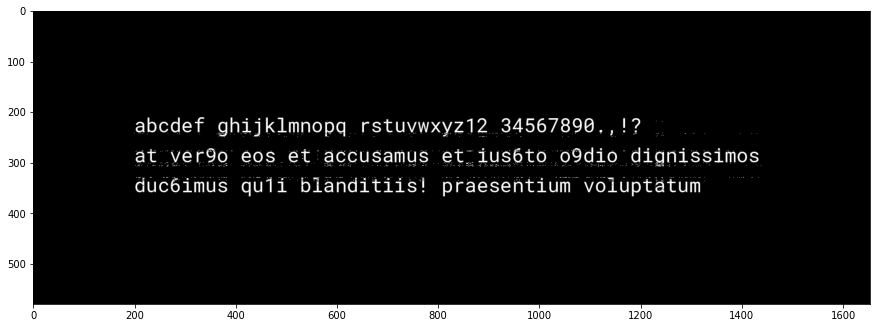

In [433]:
image = get_image("ocr/roboto_mono_test.jpg", do_reduce_noise=True, k=100)

# print(get_lines(image, 1000))
# get_columns(image, 1000)

# letters = crop_letters(image, start_left, start_top, width, height, lines, in_line)

# im = Image.fromarray(image)
# letter = im.crop((start_left, start_top, start_left+in_line * width, start_top+height))

# show_image(np.array(image))
letters = crop_letters(image, 600, True)

# l = reduce_noise(letters[5], 5)
show_image(image)


2
6


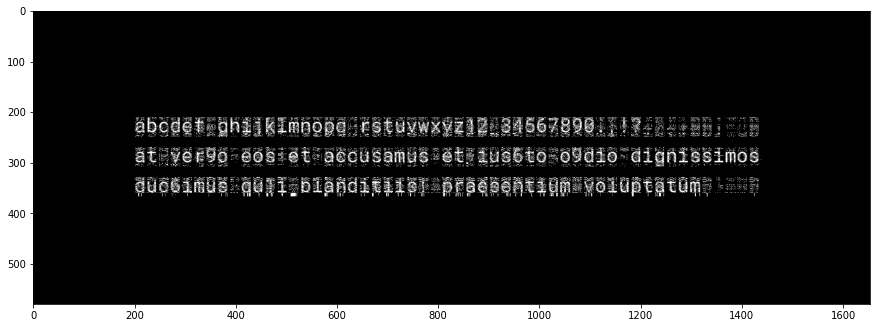

In [149]:
image = get_image("ocr/roboto_mono_test.jpg", do_reduce_noise=True, k=80)

# print(get_lines(image, 1000))
get_columns(image, 900)

# letters = crop_letters(image, start_left, start_top, width, height, lines, in_line)

# im = Image.fromarray(image)
# letter = im.crop((start_left, start_top, start_left+in_line * width, start_top+height))

show_image(np.array(image))

### Reading from images

In [881]:
rows_threshold = 800
# columns_threshold = 2000
columns_threshold = 500
margin = 4

class Point:
    """ Class represents point on which character was found """
    def __init__(self, coords, character, correlation):
        self._coords = coords
        self._character = character
        self._correlation = correlation
        
    def __lt__(self, other):
        """ Useful when sorting points. Points are divided into lines and y coordinate
            is not important when points are in the same line.
        """
        if abs(self.coords[1] - other.coords[1]) > 2 * margin:
            return True if self.coords[1] < other.coords[1] else False
        else:
            return True if self.coords[0] < other.coords[0] else False
        
    def __eq__(self, other):
        """ Useful when extracting characters because many points can have high correlation
            in specific area but just one point should be chosen to tell what character was
            found there.
        """
        if type(self) == type(other) and \
        abs(self.coords[0] - other.coords[0]) <= 2 * margin and \
        abs(self.coords[1] - other.coords[1]) <= 2 * margin:
            return True
        
        return False
        
    
    def __hash__(self):
        return hash(self._coords)
    
    @property
    def coords(self):
        return self._coords
    
    @property
    def character(self):
        return self._character
    
    @property
    def correlation(self):
        return self._correlation
    

# def get_angle_score(image, angle):
#     """ """
#     rotated = inter.rotate(image, angle, reshape=False, order=0)
#     hist = np.sum(rotated, axis=1)
#     score = np.sum((hist[1:] - hist[:-1]) ** 2)
#     return hist, score
    

# def deskew(image):
#     delta = 0.2
#     limit = 5
#     angles = np.arange(-limit, limit, delta)
#     angles = list(map(lambda x: round(x, 1), angles))

#     scores = []
#     for angle in angles:
#         hist, score = get_angle_score(image, angle)
#         scores.append(score)

#     best_score = max(scores)
#     best_angle = angles[scores.index(best_score)]

#     # correct skew
#     image = inter.rotate(image, best_angle, reshape=False, order=0)
#     print(best_angle)
    
#     return image
    
    
def rotate(image, angle, default_color=255):
    """ Rotating image by 90, 180 or 270 degrees
    
    :arg
        image:         numpy array containing image to rotate
        angle:         angle of which the image should be rotated
        default_color: in case of angle == 90 or angle == 270 it is needed 
                       to reshape array so this color will be in the new cells
                       
    :returns
        rotated image sa numpy array
    """
    n, m = image.shape
    
    # making square array to rotate it and not lose any pixel
    # when angle = 90 or angle = 270
    square_image = image
    if angle == 90 or angle == 270:
        if n > m:
            square_image = np.empty((n, n))
            square_image[:, :m] = image
            square_image[:, m:] = default_color
        elif m > n:
            square_image = np.empty((m, m))
            square_image[:n, :] = image
            square_image[n:, :] = default_color
    
    square_image = inter.rotate(square_image, angle, reshape=False, order=0)
    
    # making correct size of the image
    image = square_image
    if angle == 90:
        if n > m:
            image = np.empty((m, n))
            image = square_image[(n-m):, :]
        elif m > n:
            image = np.empty((m, n))
            image = square_image[:, :n]
            
            
    elif angle == 270:
        if n > m:
            image = np.empty((m, n))
            image = square_image[:m, :]
        elif m > n:
            image = np.empty((m, n))
            image = square_image[:, (m-n):]    
            
    return image
    

def get_possible_rows(image):
    """ Gets all possible rows in which character can be found 
    
    :arg
        image: numpy array contating image
        
    :returns
        set of integers: possible rows
    """
    possible_rows = set()
    
    lines = get_lines(image, rows_threshold)
    
    for line in lines:
        possible_rows |= set([x for x in range(line[1] - margin, line[1] + margin + 1)])
        
    return possible_rows
    
    
def get_possible_columns(image):
    """ Gets all possible columns in which character can be found 
    
    :arg
        image: numpy array contating image
        
    :returns
        set of integers: possible columns
    """
    possible_columns = set()
    
    columns = get_columns(image, columns_threshold)
    
    for column in columns:
        possible_columns |= set([y for y in range(column[1] - margin, column[1] + margin + 1)])
        
    mean_width = reduce(lambda a, b: a + b, map(lambda a: a[1] - a[0], columns)) / len(columns)
    
    return possible_columns, mean_width


def get_patterns(path):
    """ Gets list of paths to all character patterns 
    
    :arg
        path: path of the directory
        
    :return
        list of strings containing names of the files with character patterns
    """
    return os.listdir(path)
#     return ["a.jpg"]


def get_occurrence(image, pattern, possible_rows, possible_columns, pattern_name, threshold):
    """ Gets all possible occurences of character using discrete Fourier transform
    
    :arg
        image:            image as numpy array
        pattern:          pattern as numpy array
        possible_rows:    possible rows in which patterns can be found
        possible_columns: possible columns in which patterns can be found
        pattern_name:     character which funtion is looking for
        threshold:        minimal correlation to classify position as contating pattern
        
    :return
        list of objects of class Point: found occurences of pattern
    """
    occurrence = np.real(ifft2(fft2(image) * fft2(np.rot90(pattern, 2), image.shape)))
    
    highlighted_points = []
    
    for i in range(occurrence.shape[0]):
        for j in range(occurrence.shape[1]):
            if occurrence[i, j] > threshold and i in possible_rows and j in possible_columns:
                highlighted_points.append(Point((j, i), pattern_name[0], occurrence[i, j]))

    return highlighted_points


def check_rotation(image, patterns_path):
    rotation_score = dict()
    
    for angle in [90, 0, 180, 270]:
        # rotating image
        curr_image = rotate(image, angle, default_color=0)
        
        # getting first 2 rows of the rotated image (or less if there is less than 2 lines)
        possible_rows = set()

        lines = get_lines(curr_image, rows_threshold, make_equal_length=False)

        for i in range(min(len(lines), 2)):
            possible_rows |= set([x for x in range(lines[i][1] - margin, lines[i][1] + margin + 1)])

        smaller_image = np.empty((lines[min(len(lines)-1, 1)][1] + 20, curr_image.shape[1]))
        smaller_image = curr_image[:smaller_image.shape[0], :]
        
        
        # getting all possible columns of the rotated image
        possible_columns, _ = get_possible_columns(image)

        # getting all occurrences of these three vowels
        pattern_threshold = [("a.jpg", 8.5*10**6), ("e.jpg", 8.5*10**6), ("i.jpg", 8.5*10**6)]
        
        best_points = []
        
        for pattern, threshold in pattern_threshold:
            pattern_array = get_image(f"{patterns_path}/{pattern}", original=True)

            best_points += get_occurrence(smaller_image, pattern_array, 
                                                 possible_rows, possible_columns,
                                                 pattern, threshold)

        # getting sum of correlation from all found points
        rotation_score[angle] = 0
        for point in best_points:
            rotation_score[angle] = max(point.correlation, rotation_score[angle])            
    
    # getting best angle
    best_angle = 0
#     print()
    for angle, score in rotation_score.items():
#         print(angle, score)
        if score > rotation_score[best_angle]:
            best_angle = angle
    
    image = rotate(image, best_angle, default_color=0)
    
    return image, best_angle
            

def extract_characters(points, character_width):
    text = ""
    
    curr_best = points[0]
    
    for i in range(1, len(points)):
        if points[i-1] == points[i] and points[i].correlation > curr_best.correlation:
            curr_best = points[i]
        elif points[i-1] != points[i]:
            text += curr_best.character
#             print(f"({curr_best.coords[0]}, {curr_best.coords[1]}): {curr_best.correlation}")
            curr_best = points[i]
            
            if points[i].coords[1] - points[i-1].coords[1] > 2 * margin:
                text += "\n"
            elif points[i].coords[0] - points[i-1].coords[0] > 1.5 * character_width:
                text += " "
    
    text += curr_best.character
#     print(f"({curr_best.coords[0]}, {curr_best.coords[1]}): {curr_best.correlation}")

    
    return text

    
def read_text(image_path, patterns_path, threshold, k, show=False):
    image_array = get_image(image_path)
    image_array, angle = check_rotation(image_array, patterns_path)
#     angle = 0
#     image_array = rotate(image_array, 270, 0)
    image_array = reduce_noise(image_array, k)
    
    possible_rows = get_possible_rows(image_array)
    possible_columns, column_width = get_possible_columns(image_array)
    
    best_points = []
    
    for pattern in get_patterns(patterns_path):
        print(pattern, end=" ")
        pattern_array = get_image(f"{patterns_path}/{pattern}", original=True)
        
        best_points += get_occurrence(image_array, pattern_array, 
                                             possible_rows, possible_columns,
                                             pattern, threshold)

    best_points.sort()
    text = extract_characters(best_points, column_width)

    print(f"\n{text}")
    
#     for i in possible_rows:
#         for j in possible_columns:
#             best_points.append(Point((j, i), "q", 10))

    if show:
        original_image = get_image(image_path, original=True, to_grayscale=True)
        original_image = rotate(original_image, angle)
        
        show_image(original_image, best_points)
        

                               

#     best_points = []
#     text = ""
    
    return text, best_points



def edit_distance(x, y, get_distance=True):
    """ Calculating edit distance

    :arg
        x, y:         chains between which edit distance is calculated
        delta:        function used to get edit distance between two subchains (for example letters)
        get_distance: whether function is returning edit distance and parent array or just parent array

    :returns
        edit distance and parent 2d array if get_distance == True; just parent 2d array otherwise
    """

    def delta(a, b):
        """ Function calculating distance between two letters, tokens, lines, ...

        :arg
            a,b: letters, token, lines, ... between which there will be calculated edit distance

        :returns
            if the arguments are the same: 0; otherwise 1
        """

        if a == b:
            return 0
        else:
            return 1
    
    # initializing table by filling first row and column
    edit_table = np.empty((len(x) + 1, len(y) + 1))
    for i in range(len(x) + 1):
        edit_table[i, 0] = i
    for j in range(len(y) + 1):
        edit_table[0, j] = j

    # filling all the 2d array
    for i in range(1, len(x) + 1):
        for j in range(1, len(y) + 1):
            # getting minimal edit distance to get to this position in array and position itself
            minimum, position = min((edit_table[i-1, j] + 1, (i-1, j)),
                                    (edit_table[i, j-1] + 1, (i, j-1)),
                                    (edit_table[i-1, j-1] + delta(x[i-1], y[j-1]), (i-1, j-1)))
            edit_table[i, j] = minimum

    return edit_table[len(x), len(y)]



def check_correctness(text, test=False):
    file_name = "ocr/text_test.txt" if test else "ocr/text.txt"
    
    with open(file_name, "r") as file:
        correct_text = file.read()
        
        correct_characters = 0
        
        for i in range(min(len(text), len(correct_text))):
            if text[i] == correct_text[i]:
                correct_characters += 1
                
        edit_dist = edit_distance(text, correct_text)
                
        print(f"Edit distance: {int(edit_dist)}")
        print(f"Correctness: {(100 * correct_characters / len(correct_text)):.1f}%")
        print(f"Number of letters: {len(text)}")

In [850]:
# rotating
image = Image.open("ocr/roboto_mono2.jpg")
# image = image.rotate(270)
image = image.convert("L")    
image = np.array(image)
image = rotate(image, 90, default_color=255)
# show_image(image)
image = Image.fromarray(image)
with open("ocr/roboto_mono_90.jpg", "w+"):
    pass
image = image.convert("RGB")    
image.save("ocr/roboto_mono_90.jpg")

#### Roboto Mono

..jpg z.jpg b.jpg 9.jpg j.jpg !.jpg 1.jpg 7.jpg 0.jpg i.jpg s.jpg 2.jpg u.jpg c.jpg 8.jpg a.jpg d.jpg ?.jpg m.jpg ,.jpg v.jpg o.jpg 3.jpg y.jpg 4.jpg g.jpg w.jpg q.jpg 6.jpg t.jpg n.jpg h.jpg k.jpg l.jpg x.jpg f.jpg p.jpg r.jpg e.jpg 5.jpg 
molestias exgepturi siht oggaegati4 gupiditate hoh
at yerol eos et 1475234 aggusamus et iustoy odio?
dighissimos dugimus qui blahditiis! 968140y yoluptati


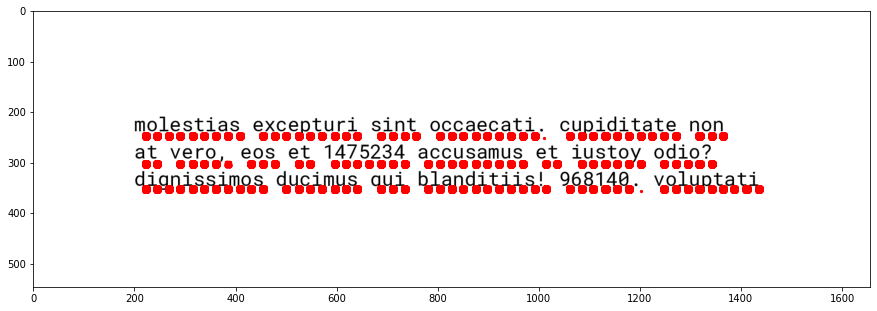

Edit distance: 21
Correctness: 86.5%
Number of letters: 154


In [895]:
text, points = read_text("ocr/roboto_mono2.jpg", "ocr/roboto_mono_2", 1.4 * 10 ** 6, k=105, show=True)

check_correctness(text, test=False)

..jpg z.jpg b.jpg 9.jpg j.jpg !.jpg 1.jpg 7.jpg 0.jpg i.jpg s.jpg 2.jpg u.jpg c.jpg 8.jpg a.jpg d.jpg ?.jpg m.jpg ,.jpg v.jpg o.jpg 3.jpg y.jpg 4.jpg g.jpg w.jpg q.jpg 6.jpg t.jpg n.jpg h.jpg k.jpg l.jpg x.jpg f.jpg p.jpg r.jpg e.jpg 5.jpg 
molestias exgepturi siht oggaegatiy gupiditate hoh
at yero, eos et 1475234 aggusamus et iustoy odio?
dighissimos dugimus qui blahditiis! 968140y yoluptati


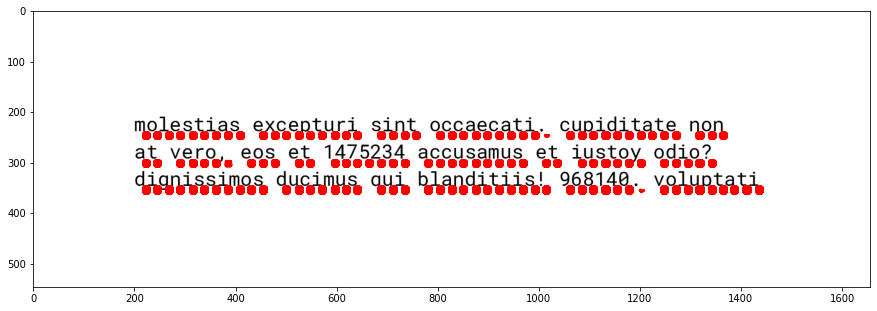

Edit distance: 20
Correctness: 87.2%
Number of letters: 154


In [882]:
text, points = read_text("ocr/roboto_mono2.jpg", "ocr/roboto_mono_2", 1.35 * 10 ** 6, k=200, show=True)

check_correctness(text, test=False)

..jpg z.jpg b.jpg 9.jpg j.jpg !.jpg 1.jpg 7.jpg 0.jpg i.jpg s.jpg 2.jpg u.jpg c.jpg 8.jpg a.jpg d.jpg ?.jpg m.jpg ,.jpg v.jpg o.jpg 3.jpg y.jpg 4.jpg g.jpg w.jpg q.jpg 6.jpg t.jpg n.jpg h.jpg k.jpg l.jpg x.jpg f.jpg p.jpg r.jpg e.jpg 5.jpg 
molestias exgepturi siht oggaegati4 gupiditate hoh
at yerol eos et 1475234 aggusamus et iustoy odio?
dighissimos dudimus qui blahditiis! 968140y yoluptati


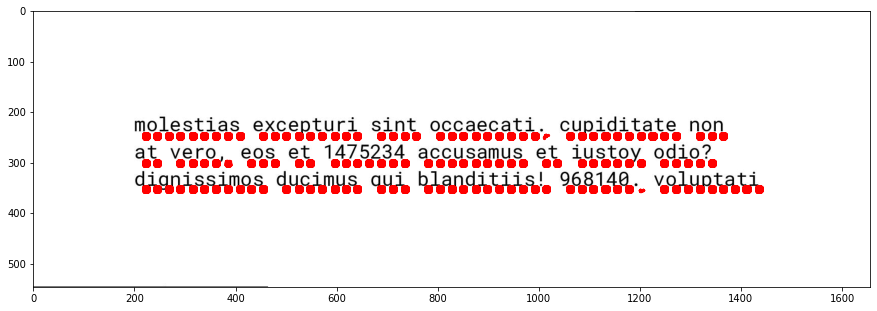

Edit distance: 21
Correctness: 86.5%
Number of letters: 154


In [883]:
text, points = read_text("ocr/roboto_mono_180.jpg", "ocr/roboto_mono_1", 1.35 * 10 ** 6, k=200, show=True)

check_correctness(text, test=False)

..jpg z.jpg b.jpg 9.jpg j.jpg !.jpg 1.jpg 7.jpg 0.jpg i.jpg s.jpg 2.jpg u.jpg c.jpg 8.jpg a.jpg d.jpg ?.jpg m.jpg ,.jpg v.jpg o.jpg 3.jpg y.jpg 4.jpg g.jpg w.jpg q.jpg 6.jpg t.jpg n.jpg h.jpg k.jpg l.jpg x.jpg f.jpg p.jpg r.jpg e.jpg 5.jpg 
molestias exgepturi siht oggaegati4 gupiditate hoh
at yerol eos et 1475234 aggusamus et iustoy odio?
dighissimos dugimus qui blahditiis! 968140y yoluptati


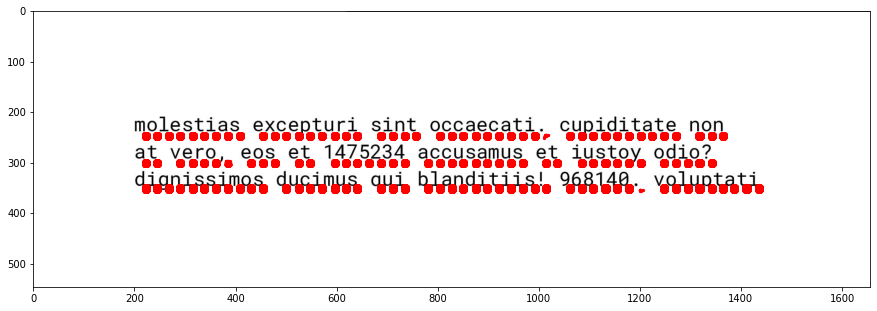

Edit distance: 21
Correctness: 86.5%
Number of letters: 154


In [884]:
text, points = read_text("ocr/roboto_mono_90.jpg", "ocr/roboto_mono_1", 1.35 * 10 ** 6, k=200, show=True)

check_correctness(text, test=False)

..jpg z.jpg b.jpg 9.jpg j.jpg !.jpg 1.jpg 7.jpg 0.jpg i.jpg s.jpg 2.jpg u.jpg c.jpg 8.jpg a.jpg d.jpg ?.jpg m.jpg ,.jpg v.jpg o.jpg 3.jpg y.jpg 4.jpg g.jpg w.jpg q.jpg 6.jpg t.jpg n.jpg h.jpg k.jpg l.jpg x.jpg f.jpg p.jpg r.jpg e.jpg 5.jpg 
molestias exgepturi siht oggaegati4 gupiditate hoh
at yeroy eos et 1475234 aggusamus et iustoy odio?
dighissimos dudimus qui blahditiis! 968140y yoluptati


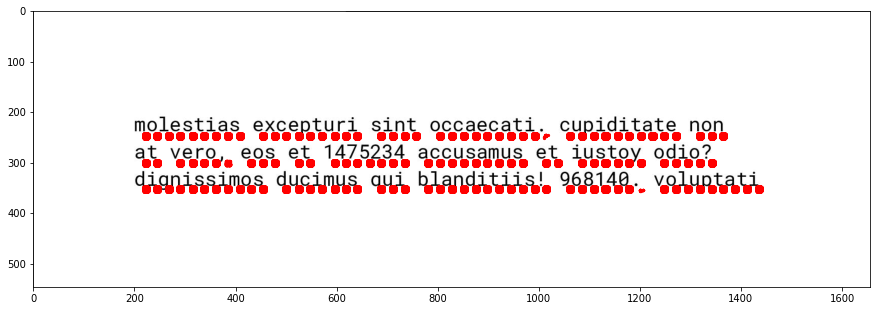

Edit distance: 21
Correctness: 86.5%
Number of letters: 154


In [885]:
text, points = read_text("ocr/roboto_mono_270.jpg", "ocr/roboto_mono_1", 1.35 * 10 ** 6, k=200, show=True)

check_correctness(text, test=False)

..jpg z.jpg b.jpg 9.jpg j.jpg !.jpg 1.jpg 7.jpg 0.jpg i.jpg s.jpg 2.jpg u.jpg c.jpg 8.jpg a.jpg d.jpg ?.jpg m.jpg ,.jpg v.jpg o.jpg 3.jpg y.jpg 4.jpg g.jpg w.jpg q.jpg 6.jpg t.jpg n.jpg h.jpg k.jpg l.jpg x.jpg f.jpg p.jpg r.jpg e.jpg 5.jpg 
abgdef ghijklmhopq rstuywxyz12 34567890wl!?
at yer9o eos et adgusamus et ius6to o9dio dighissimos
dug6imus qu1i blahditiis! praesehtium yoluptatum


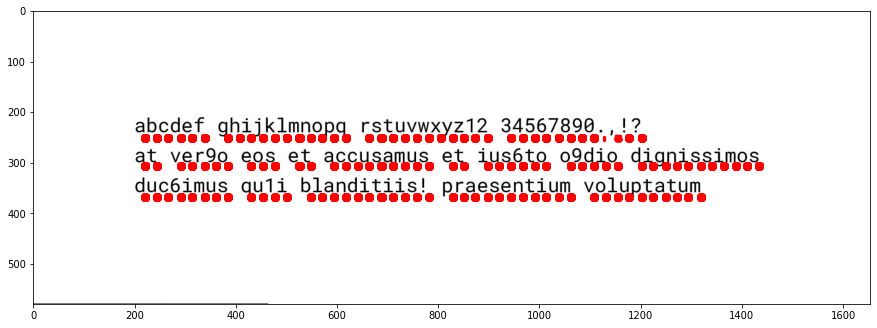

Edit distance: 17
Correctness: 88.6%
Number of letters: 146


In [886]:
# works for 180
text, points = read_text("ocr/roboto_mono_test_180.jpg", "ocr/roboto_mono_1", 1.4 * 10 ** 6, k=110, show=True)

check_correctness(text, test=True)

..jpg z.jpg b.jpg 9.jpg j.jpg !.jpg 1.jpg 7.jpg 0.jpg i.jpg s.jpg 2.jpg u.jpg c.jpg 8.jpg a.jpg d.jpg ?.jpg m.jpg ,.jpg v.jpg o.jpg 3.jpg y.jpg 4.jpg g.jpg w.jpg q.jpg 6.jpg t.jpg n.jpg h.jpg k.jpg l.jpg x.jpg f.jpg p.jpg r.jpg e.jpg 5.jpg 
abddef ghijklmhopq rstuywxyz12 34567890wj!?
at yeb9d eds et addusamus et ius6td d9did dighissimds
dud6imus qu1i blahditiis! praesehtium yoluptatum


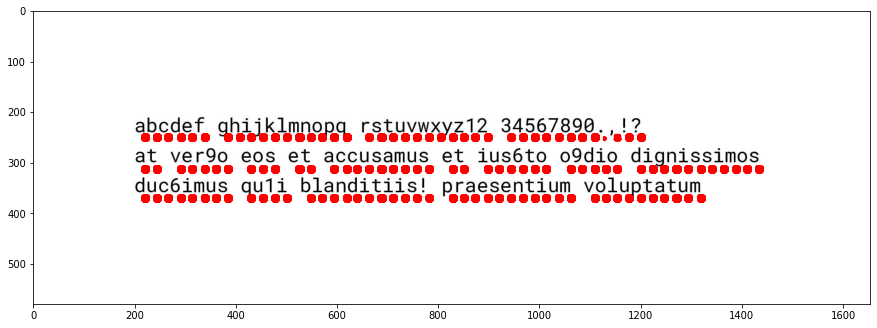

Edit distance: 24
Correctness: 83.9%
Number of letters: 146


In [887]:
# works for 90
image = get_image("ocr/roboto_mono_test.jpg", original=True)

text, points = read_text("ocr/roboto_mono_test_90.jpg", "ocr/roboto_mono_1", 1.4 * 10 ** 6, k=110, show=True)

check_correctness(text, test=True)

..jpg z.jpg b.jpg 9.jpg j.jpg !.jpg 1.jpg 7.jpg 0.jpg i.jpg s.jpg 2.jpg u.jpg c.jpg 8.jpg a.jpg d.jpg ?.jpg m.jpg ,.jpg v.jpg o.jpg 3.jpg y.jpg 4.jpg g.jpg w.jpg q.jpg 6.jpg t.jpg n.jpg h.jpg k.jpg l.jpg x.jpg f.jpg p.jpg r.jpg e.jpg 5.jpg 
abgdef ghijklmhopq rstuywxyz12 3456 890wl!?
at yer9g eos et aggusamus et ius6to o9dio dighissimgs
dug6imus qu1i blahditiis! praesehti m yoluptatum


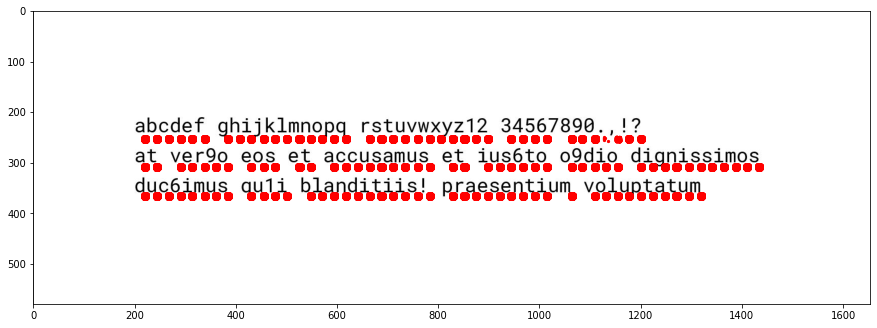

Edit distance: 21
Correctness: 85.9%
Number of letters: 146


In [888]:
# works for 270
image = get_image("ocr/roboto_mono_test.jpg", original=True)

text, points = read_text("ocr/roboto_mono_test_270.jpg", "ocr/roboto_mono_1", 1.4 * 10 ** 6, k=110, show=True)

check_correctness(text, test=True)

..jpg z.jpg b.jpg 9.jpg j.jpg !.jpg 1.jpg 7.jpg 0.jpg i.jpg s.jpg 2.jpg u.jpg c.jpg 8.jpg a.jpg d.jpg ?.jpg m.jpg ,.jpg v.jpg o.jpg 3.jpg y.jpg 4.jpg g.jpg w.jpg q.jpg 6.jpg t.jpg n.jpg h.jpg k.jpg l.jpg x.jpg f.jpg p.jpg r.jpg e.jpg 5.jpg 
abddef ghijklmhopq rstuvwxyz12 34567890w,!?
at yer9o eos et aggusamus et ius6to o9dio dighissimos
dug6imus qu1i blahditiis! praesehtium yoluptatum


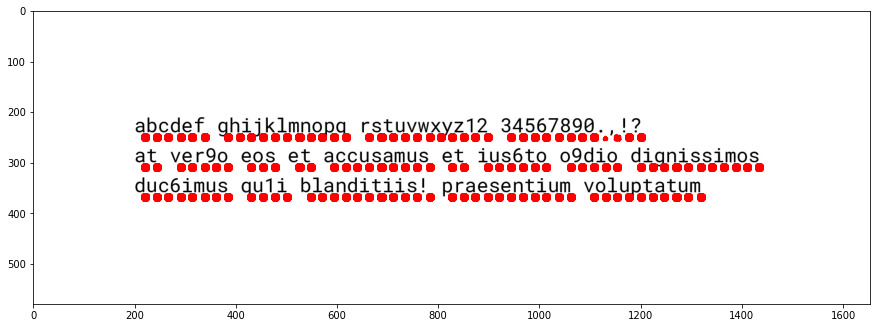

Edit distance: 15
Correctness: 89.9%
Number of letters: 146


In [889]:
# that's nice

image = get_image("ocr/roboto_mono_test.jpg", original=True)

text, points = read_text("ocr/roboto_mono_test.jpg", "ocr/roboto_mono_2", 1.4 * 10 ** 6, k=105, show=True)

check_correctness(text, test=True)

..jpg z.jpg b.jpg 9.jpg j.jpg !.jpg 1.jpg 7.jpg 0.jpg i.jpg s.jpg 2.jpg u.jpg c.jpg 8.jpg a.jpg d.jpg ?.jpg m.jpg ,.jpg v.jpg o.jpg 3.jpg y.jpg 4.jpg g.jpg w.jpg q.jpg 6.jpg t.jpg n.jpg h.jpg k.jpg l.jpg x.jpg f.jpg p.jpg r.jpg e.jpg 5.jpg 
abddef ghijklmhopq rstuywxyz12 34567890wj!?
at yer9o eos et addusamus et ius6to o9dio dighissimos
dud6imus qu1i blahditiis! praesehtium yoluptatum


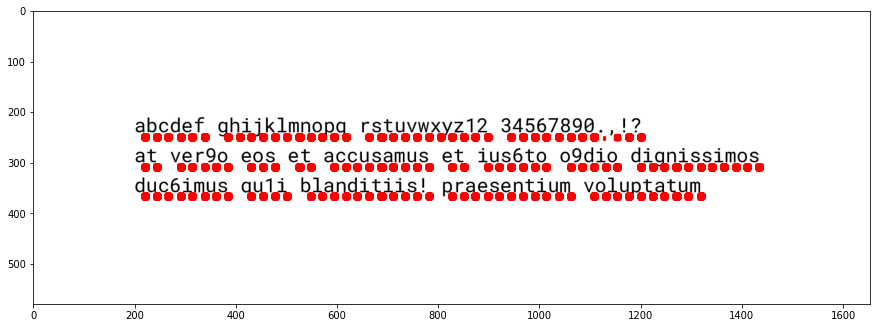

Edit distance: 17
Correctness: 88.6%
Number of letters: 146


In [771]:
# that's nice
image = get_image("ocr/roboto_mono_test.jpg", original=True)

text, points = read_text("ocr/roboto_mono_test.jpg", "ocr/roboto_mono_1", 1.4 * 10 ** 6, k=110, show=True)

check_correctness(text, test=True)

In [53]:
# start_top = 612
margin = 5
    
    
class Point:
    def __init__(self, coords, character, correlation):
        self._coords = coords
        self._character = character
        self._correlation = correlation
        
    def __lt__(self, other):
        if abs(self.coords[1] - other.coords[1]) > 2 * margin:
            return True if self.coords[1] < other.coords[1] else False
        else:
            return True if self.coords[0] < other.coords[0] else False
        
    def __eq__(self, other):
        if type(self) == type(other) and \
        abs(self.coords[0] - other.coords[0]) <= 2 * margin and \
        abs(self.coords[1] - other.coords[1]) <= 2 * margin:
            return True
        
        return False
        
    
    def __hash__(self):
        return hash(self._coords)
    
    @property
    def coords(self):
        return self._coords
    
    @property
    def character(self):
        return self._character
    
    @property
    def correlation(self):
        return self._correlation
    

def get_patterns(text_type):
#     return os.listdir(f"ocr/{text_type}")
    return ["y.jpg"]
    
    
# def get_array(filename, original=False, invert=True):
#     image = Image.open(filename)
    
#     if not original:
#         image = image.convert("L")
#         if invert:
#             image = PIL.ImageOps.invert(image)

#     return np.array(image)


def get_angle_score(image, angle):
    rotated = inter.rotate(image, angle, reshape=False, order=0)
    hist = np.sum(rotated, axis=1)
    score = np.sum((hist[1:] - hist[:-1]) ** 2)
    return hist, score


def deskew(image):
    delta = 0.2
    limit = 5
    angles = np.arange(-limit, limit, delta)
    angles = list(map(lambda x: round(x, 1), angles))

    scores = []
    for angle in angles:
        hist, score = get_angle_score(image, angle)
        scores.append(score)

    best_score = max(scores)
    best_angle = angles[scores.index(best_score)]

    # correct skew
    image = inter.rotate(image, best_angle, reshape=False, order=0)
    print(best_angle)
    
    return image
    

def get_possible_rows(start_top, height, lines):
    rows = set()
    
    for i in range(1, lines+1):
        rows |= set([x for x in range(
            start_top + int(i*height) - margin, start_top + int(i*height) + margin + 1)])
        
    return rows
    
    
def get_possible_columns(start_left, width, in_line):
    columns = set()
    
    for i in range(1, in_line+1):
        columns |= set([y for y in range(
            start_left + int(i*width) - margin, start_left + int(i*width) + margin + 1)])
        
    return columns


def get_occurrence(image, pattern, possible_rows, possible_columns, pattern_name, threshold):
    occurrence = np.real(ifft2(fft2(image) * fft2(np.rot90(pattern, 2), image.shape)))
    
    highlighted_points = []
    
    for i in range(occurrence.shape[0]):
        for j in range(occurrence.shape[1]):
            if occurrence[i, j] > threshold and i in possible_rows and j in possible_columns:
                highlighted_points.append(Point((j, i), pattern_name[0], occurrence[i, j]))

    return highlighted_points


def extract_characters(points, width):
    text = ""
    
    curr_best = points[0]
    print()
    
    for i in range(1, len(points)):
        if points[i-1] == points[i] and points[i].correlation > curr_best.correlation:
            curr_best = points[i]
        elif not points[i-1] == points[i]:
            text += curr_best.character
            print(f"({curr_best.coords[0]}, {curr_best.coords[1]}): {curr_best.correlation}")
            curr_best = points[i]
            
            if points[i].coords[1] - points[i-1].coords[1] > 2 * margin:
                text += "\n"
            elif points[i].coords[0] - points[i-1].coords[0] > width:
                text += " "
    
    text += curr_best.character
    print(f"({curr_best.coords[0]}, {curr_best.coords[1]}): {curr_best.correlation}")

    
    return text

    
def read_text(text_type, start_left, start_top, width, height, lines, in_line, threshold, k):
#     image_array = get_array(f"ocr/{text_type}_skewed.jpg")
#     image_array = get_array(f"ocr/{text_type}_test.jpg")
    image_array = get_array(f"ocr/{text_type}_test.jpg")
    image_array = reduce_noise(image_array, k)
#     image_array = deskew(image_array)
    
    possible_rows = get_possible_rows(start_top, height, lines)
    possible_columns = get_possible_columns(start_left, width, in_line)
    
    highlighted_points = []
    
    for pattern in get_patterns(text_type):
        print(pattern, end=" ")
        pattern_array = get_array(f"ocr/{text_type}/{pattern}")
        
        highlighted_points += get_occurrence(image_array, pattern_array, 
                                             possible_rows, possible_columns,
                                             pattern, threshold)

    highlighted_points.sort()
    text = extract_characters(highlighted_points, width)
#     print(highlighted_points.coords)
    
#     for i in range(len(highlighted_points)):
#         print(highlighted_points[i].coords)

    return text, highlighted_points

    
def separate_coordinates(points):
    points_x = list(map(lambda point: point.coords[0], points))
    points_y = list(map(lambda point: point.coords[1], points))

    return points_x, points_y

    
def check_correctness(text):
    with open("ocr/text.txt", "r") as file:
        correct_text = file.read()
        
        correct_characters = 0
        
        for i in range(min(len(text), len(correct_text))):
            if text[i] == correct_text[i]:
                correct_characters += 1
                
        return 100 * correct_characters / len(correct_text)
    
    
def get_all_letters():
    """ Returns list of all lowercase and uppercase letters. """
    lowercase = list(map(chr, range(ord('a'), ord('z')+1)))
    uppercase = list(map(chr, range(ord('A'), ord('Z')+1)))
    
    return lowercase + uppercase


def count_letters(text):
    letter_counts = dict()
    
    letters = get_all_letters()
    
    for character in text:
        if character in letters:
            if character in letter_counts:
                letter_counts[character] += 1
            else:
                letter_counts[character] = 1
                
    letter_counts = list(letter_counts)
    letter_counts.sort()
    
    for letter, occurrences in letter_counts:
        print(f"{letter}: {occurrences}")

### roboto mono

In [41]:
start_left = 202
start_top = 197
width = 23.3
height = 59
lines = 17
in_line = 53

In [10]:
# crop_letters("ocr/roboto_mono_test.jpg", start_left, start_top, width, height, lines, in_line)

# show_image(letter)

In [43]:
# text, points = read_text("roboto_mono", start_left, start_top, width, height, lines, in_line, 1.35 * 10**6)
text, points = read_text("roboto_mono", start_left, start_top, width, height, lines, in_line, 7 * 10**6)

print("\n" + text)

y.jpg 
(759, 255): 7442249.999999999
(829, 255): 9987142.0
(292, 314): 7431593.999999999
(1109, 373): 7429311.999999997

y y
y
y


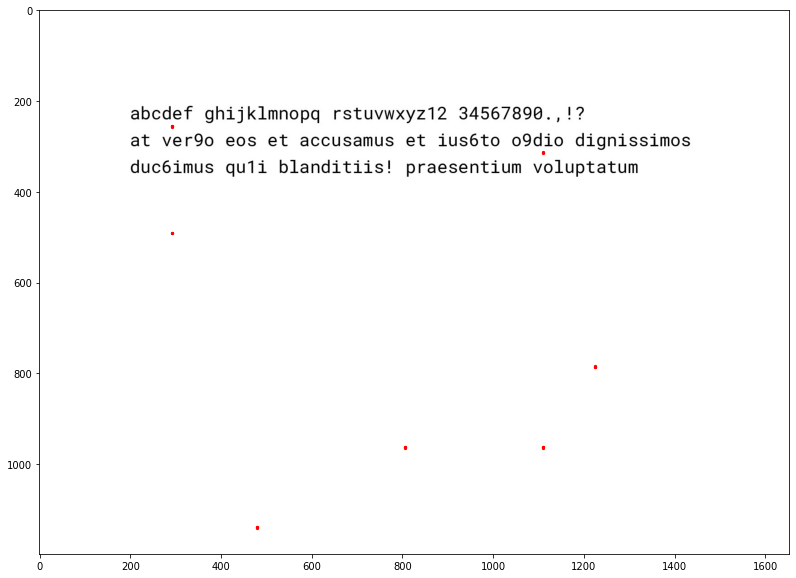

In [54]:
original_image = get_array(f"ocr/roboto_mono_test.jpg", original=True)
# original_image = inter.rotate(original_image, -30, reshape=False, order=0)
# original_image = inter.rotate(original_image, 30, reshape=False, order=0)
# points = [Point((x, y), "", 0) for y in get_possible_rows(start_top, height, lines)
#           for x in get_possible_columns(start_left, width, in_line)]
show_image(original_image, points)
# deskew(original_image)

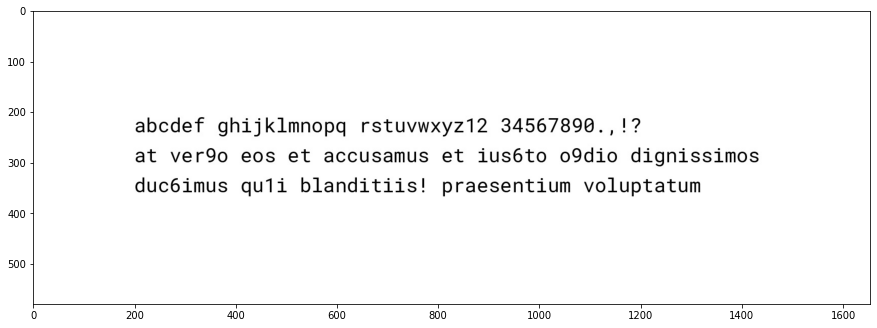

In [50]:
show_image(original_image, [])

y.jpg 
(292, 255): 7872432.999999995
(1109, 314): 7278519.999999997
(292, 491): 7361254.999999996
(1225, 786): 7448909.999999996
(805, 963): 7607785.999999999
(1109, 963): 7431805.999999998
(479, 1140): 7426934.999999998

y
y
y
y
y y
y


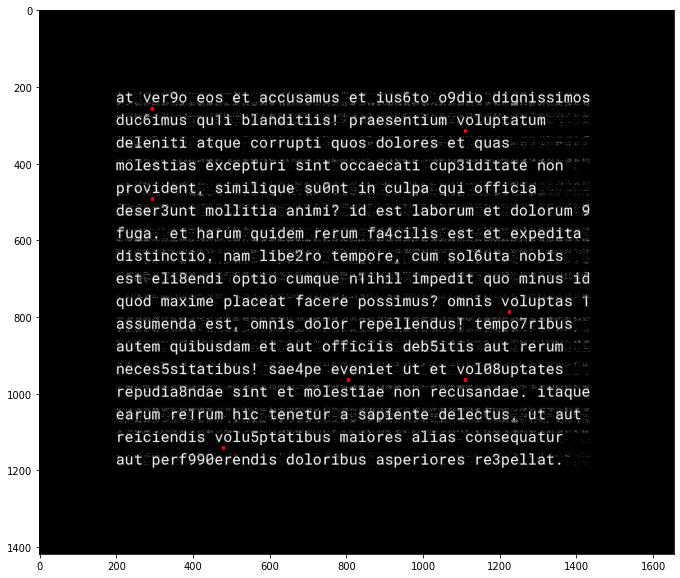

In [50]:
image = get_array(f"ocr/roboto_mono.jpg")
image2 = reduce_noise(image, 500)

text, points = read_text("roboto_mono", start_left, start_top, width, height, lines, in_line, 7 * 10**6, 450)

print("\n" + text)


show_image(image2, points)

### courier new

In [21]:
start_left = 200
start_top = 197
width = 23.3
height = 50.8
lines = 17
in_line = 53

In [9]:
# crop_letters("ocr/roboto_mono_test.jpg", start_left, start_top, width, height, lies, in_line)

# show_image(letter)

In [22]:
text, points = read_text("courier_new", start_left, start_top, width, height, lines, in_line, 1.4 * 10**6)
print("\n" + text)

..jpg z.jpg b.jpg 9.jpg j.jpg !.jpg 1.jpg 7.jpg 0.jpg i.jpg s.jpg 2.jpg u.jpg c.jpg 8.jpg a.jpg d.jpg ?.jpg m.jpg ,.jpg v.jpg o.jpg 3.jpg 4.jpg g.jpg w.jpg q.jpg 6.jpg t.jpg n.jpg h.jpg k.jpg l.jpg x.jpg f.jpg p.jpg r.jpg e.jpg 5.jpg 
at ver9o eos et accusamus et ius6to o9dio dignissimos
duc6imus qu1i blanditiis! praesentium voluptatum
deleniti atque corrupti quos dolores et quas


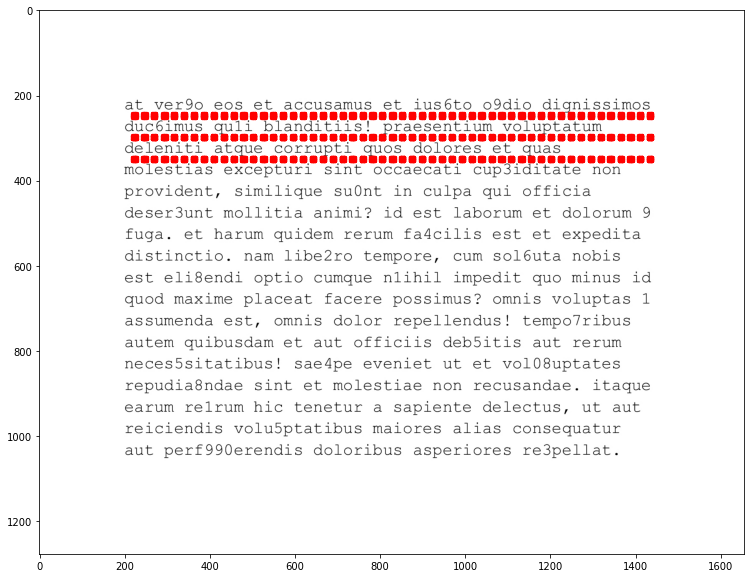

In [24]:
original_image = get_array(f"ocr/courier_new.jpg", original=True)
points = [Point((x, y), "", 0) for y in get_possible_rows() for x in get_possible_columns()]
show_image(original_image, points)

In [132]:
rate = check_correctness(text)
rate

99.42922374429224

In [58]:
a = set([2,3])
a |= {2,4, 3}
a

{2, 3, 4}

In [68]:
get_possible_rows()

[346, 347, 348, 349, 350, 351, 352, 353, 295, 296, 297, 298, 299, 300, 301, 302, 244, 245, 246, 247, 248, 249, 250, 251]


In [69]:
get_possible_columns()

[1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1244, 1245, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 219, 220, 221, 222, 223, 224, 225, 226, 1248, 1249, 1250, 1251, 1246, 1247, 242, 243, 244, 245, 246, 247, 248, 249, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 265, 266, 267, 268, 269, 270, 271, 272, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 289, 290, 291, 292, 293, 294, 295, 296, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 312, 313, 314, 315, 316, 317, 318, 319, 1344, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 335, 336, 337, 338, 339, 340, 341, 342, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 359, 360, 361, 362, 363, 364, 365, 366,

In [13]:
[(x, y) for x in get_possible_rows() for y in get_possible_columns()]

[(344, 1033),
 (344, 1034),
 (344, 1035),
 (344, 1036),
 (344, 1037),
 (344, 1038),
 (344, 1039),
 (344, 1040),
 (344, 1041),
 (344, 1042),
 (344, 1043),
 (344, 1429),
 (344, 1057),
 (344, 1058),
 (344, 1059),
 (344, 1060),
 (344, 1061),
 (344, 1062),
 (344, 1063),
 (344, 1064),
 (344, 1065),
 (344, 1066),
 (344, 1067),
 (344, 1080),
 (344, 1081),
 (344, 1082),
 (344, 1083),
 (344, 1084),
 (344, 1085),
 (344, 1086),
 (344, 1087),
 (344, 1088),
 (344, 1089),
 (344, 1090),
 (344, 1103),
 (344, 1104),
 (344, 1105),
 (344, 1106),
 (344, 1107),
 (344, 1108),
 (344, 1109),
 (344, 1110),
 (344, 1111),
 (344, 1112),
 (344, 1113),
 (344, 1127),
 (344, 1128),
 (344, 1129),
 (344, 1130),
 (344, 1131),
 (344, 1132),
 (344, 1133),
 (344, 1134),
 (344, 1135),
 (344, 1136),
 (344, 1137),
 (344, 1243),
 (344, 1244),
 (344, 1245),
 (344, 1246),
 (344, 1150),
 (344, 1151),
 (344, 1152),
 (344, 1153),
 (344, 1154),
 (344, 1155),
 (344, 1156),
 (344, 1157),
 (344, 1158),
 (344, 1159),
 (344, 1160),
 (344,

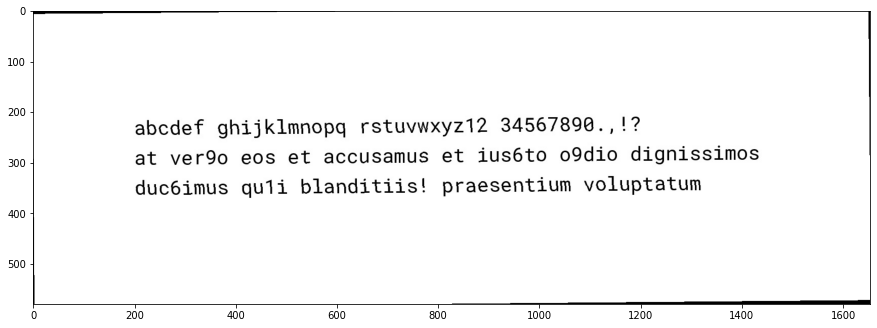

In [135]:
data = inter.rotate(original_image, 0.5, reshape=False, order=0)
fig, ax = plt.subplots(1, 1, figsize=(15,10))

ax.imshow(data)
plt.show()

In [162]:
image = 
image = inter.rotate(image, best_angle, reshape=False, order=0)

3.23

In [200]:
l = [(2, 4),(3, 5), (4, 8)]
reduce(lambda a, b: a + b, map(lambda a: a[1] - a[0], l))

8